# NR Dataset Exploratory Analysis Demo

This notebook demonstrates exploratory analysis of protein sequences from the NR (Non-Redundant) database using our sample datasets.

## Dataset Overview
- **Sample**: `NR_sample_5proteins.fasta` (5 protein sequences)
- **Metadata**: `NR_sample_5proteins_metadata.txt` (GenPept format)
- **Size**: Small sample perfect for demonstration
- **Quality**: High-quality RefSeq curated proteins


In [1]:
# !pip install numpy pandas matplotlib seaborn


In [3]:
# !pip install biopython scipy ete3

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import os
from pathlib import Path

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Define paths - CORRECTED
DATA_DIR = Path('dataset')  # Changed from '../datasets' to 'dataset'
FASTA_FILE = DATA_DIR / 'NR_sample_5proteins.fasta'
METADATA_FILE = DATA_DIR / 'NR_sample_5proteins_metadata.txt'

print(f"Data directory: {DATA_DIR}")
print(f"FASTA file exists: {FASTA_FILE.exists()}")
print(f"Metadata file exists: {METADATA_FILE.exists()}")

Data directory: dataset
FASTA file exists: True
Metadata file exists: True


Neither ETE3 nor ETE4 found. Some visualizations will be skipped.
PROTEIN SEQUENCE ANALYSIS PIPELINE
Parsing FASTA and metadata files...
Parsed 5 protein sequences

1. Analyzing sequence properties...

=== SEQUENCE PROPERTIES ANALYSIS ===

Sequence Properties Summary:
            ID  Length  Molecular_Weight  Isoelectric_Point  Instability_Index
0  NP_000508.1     142          15257.36               8.72               6.97
1  NP_001001.1     249          28696.22              10.90              54.54
2  NP_001002.1     194          22126.56              10.09              39.69
3  NP_001003.1     208          24204.89              10.32              50.18
4  NP_001009.1     145          17039.91              10.39              44.44

Creating sequence property visualizations...


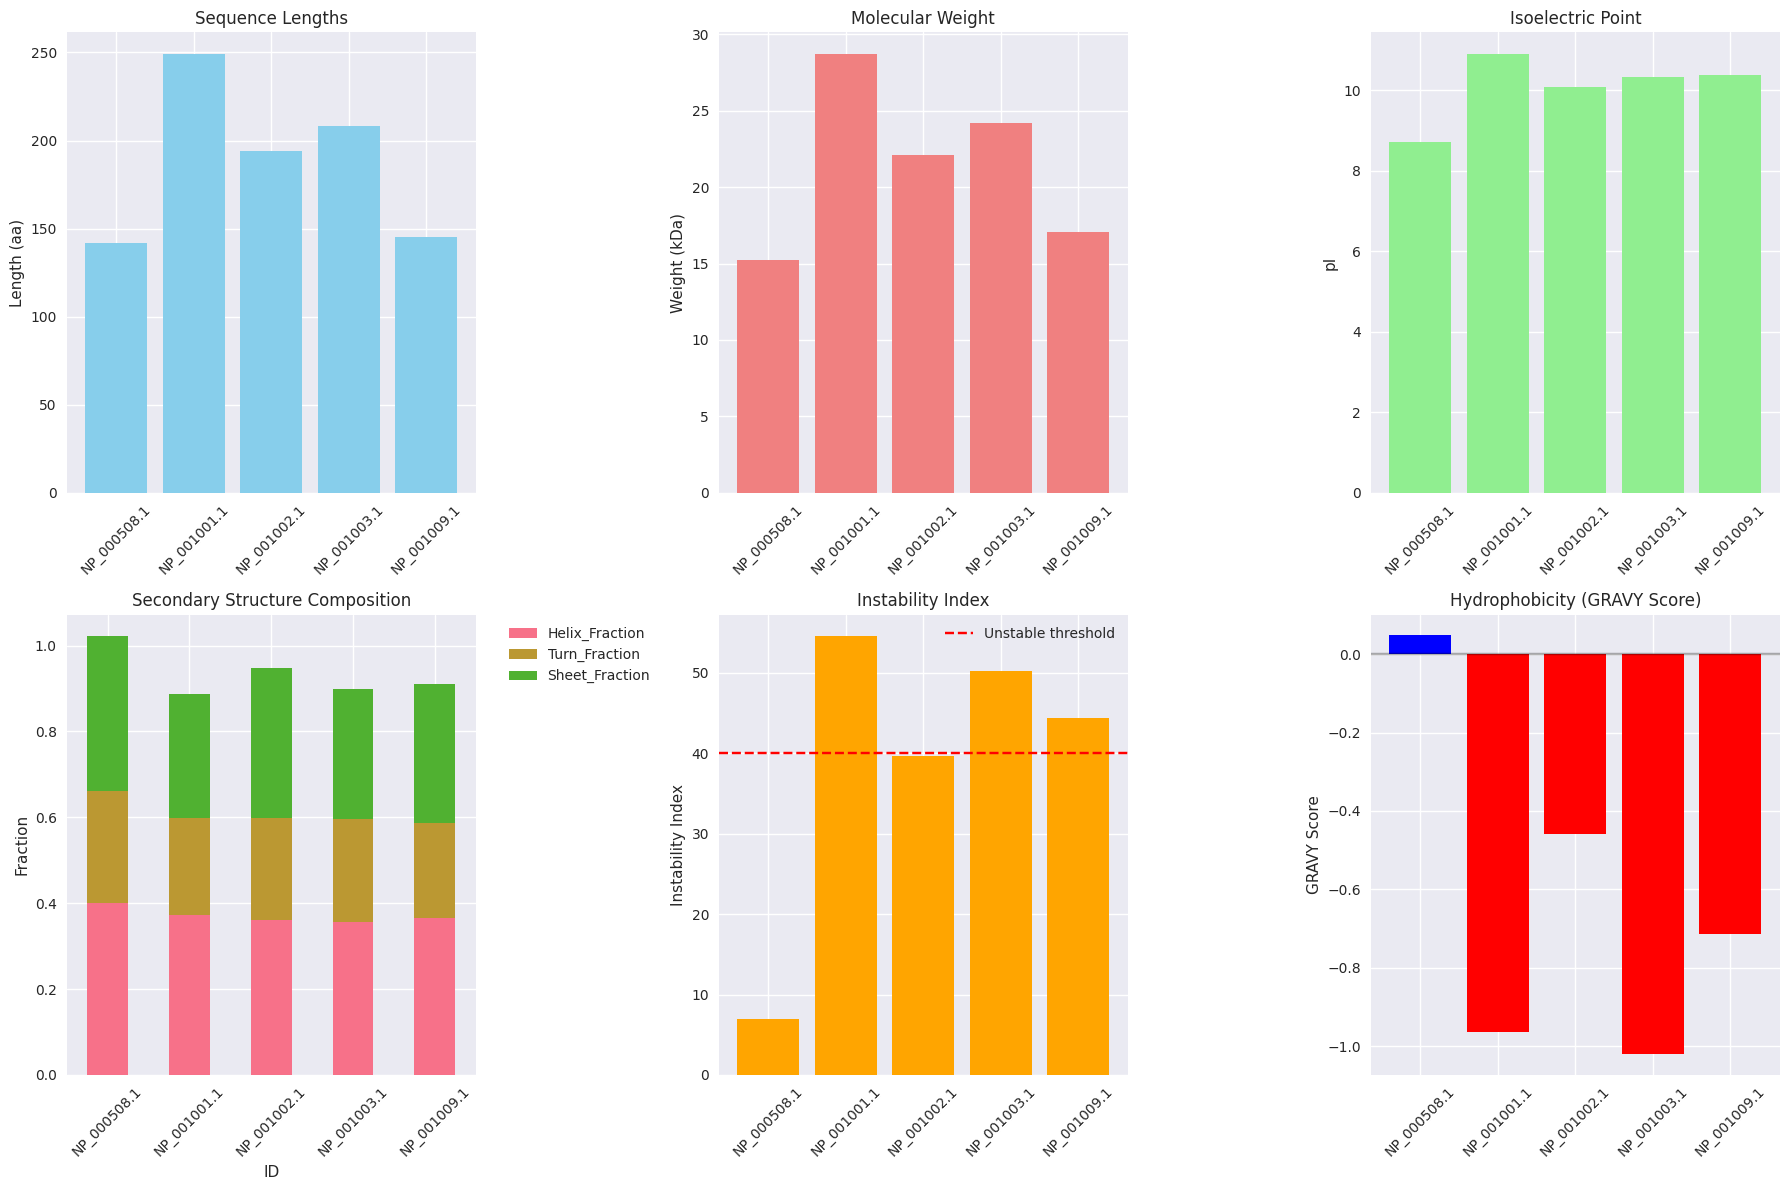


2. Analyzing amino acid composition...

=== AMINO ACID COMPOSITION ANALYSIS ===


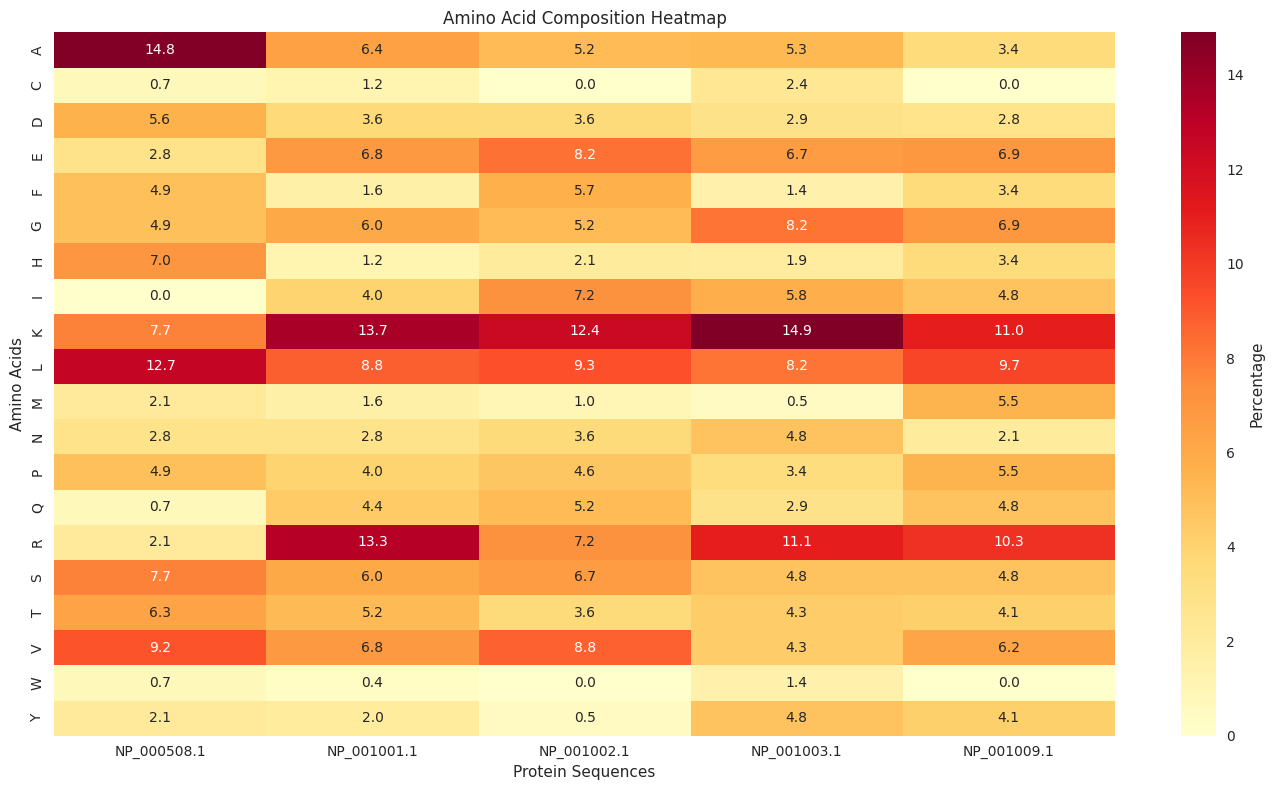


Amino Acid Composition Statistics:
ID     NP_000508.1  NP_001001.1  NP_001002.1  NP_001003.1  NP_001009.1
count        20.00        20.00        20.00        20.00        20.00
mean          5.00         5.00         5.00         5.00         5.00
std           4.03         3.70         3.33         3.50         2.98
min           0.00         0.40         0.00         0.48         0.00
25%           2.11         1.91         3.22         2.76         3.45
50%           4.93         4.22         5.15         4.57         4.83
75%           7.22         6.53         7.22         6.01         6.38
max          14.79        13.65        12.37        14.90        11.03

3. Calculating sequence distances...

=== SEQUENCE DISTANCE CALCULATION ===
Pairwise Distance Matrix:
             NP_000508.1  NP_001001.1  NP_001002.1  NP_001003.1  NP_001009.1
NP_000508.1        0.000        0.105        0.111        0.110        0.119
NP_001001.1        0.105        0.000        0.096        0.092     

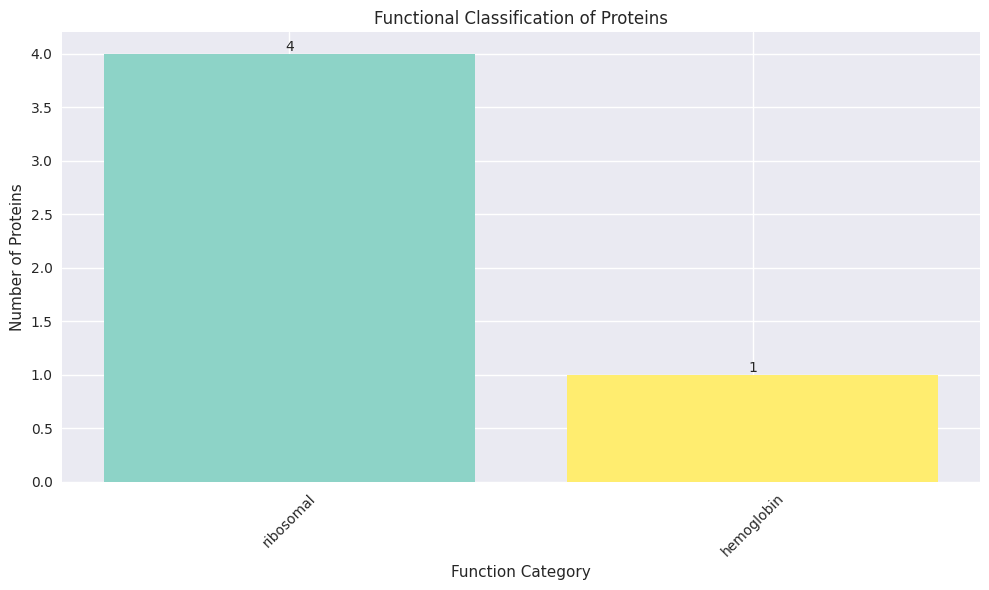

Functional Classification:
            ID Primary_Function  \
0  NP_000508.1       hemoglobin   
1  NP_001001.1        ribosomal   
2  NP_001002.1        ribosomal   
3  NP_001003.1        ribosomal   
4  NP_001009.1        ribosomal   

                                         Description  
0  NP_000508.1 hemoglobin subunit alpha [Homo sap...  
1    NP_001001.1 ribosomal protein S6 [Homo sapiens]  
2  NP_001002.1 small ribosomal subunit protein eS...  
3  NP_001003.1 small ribosomal subunit protein eS...  
4  NP_001009.1 small ribosomal subunit protein uS...  

6. Generating comprehensive report...

COMPREHENSIVE PROTEIN ANALYSIS REPORT

Dataset Overview:
- Number of proteins analyzed: 5
- Average sequence length: 187.6 aa
- Length range: 142-249 aa

Physicochemical Properties:
- Average molecular weight: 21.5 kDa
- Average isoelectric point: 10.08
- Average instability index: 39.16
- Stable proteins (II < 40): 2/5

Sequence Similarity:
- Average pairwise distance: 0.106
- Most simila

In [7]:
#!/usr/bin/env python3
"""
Comprehensive protein sequence analysis using ETE3/4 and other bioinformatics tools.
This script analyzes GenBank protein data for phylogenetic relationships,
sequence properties, and functional annotations.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import re
from collections import defaultdict, Counter
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Try to import ETE3 or ETE4
try:
    from ete3 import Tree, faces, AttrFace, TreeStyle, NodeStyle
    ETE_VERSION = 3
    print("Using ETE3")
except ImportError:
    try:
        from ete4 import Tree, faces, AttrFace, TreeStyle, NodeStyle
        ETE_VERSION = 4
        print("Using ETE4")
    except ImportError:
        print("Neither ETE3 nor ETE4 found. Some visualizations will be skipped.")
        ETE_VERSION = None

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

class ProteinAnalyzer:
    """Class for comprehensive protein sequence analysis."""
    
    def __init__(self, fasta_file_path=None, metadata_file_path=None, genbank_file_path=None):
        """Initialize with FASTA + metadata files or GenBank file."""
        self.fasta_file = fasta_file_path
        self.metadata_file = metadata_file_path
        self.genbank_file = genbank_file_path
        self.sequences = []
        self.metadata = []
        
        if fasta_file_path and metadata_file_path:
            self.parse_fasta_and_metadata()
        elif genbank_file_path:
            self.parse_genbank_data()
        else:
            raise ValueError("Provide either (fasta_file + metadata_file) or genbank_file")
    
    def parse_fasta_and_metadata(self):
        """Parse FASTA file and metadata file separately."""
        print("Parsing FASTA and metadata files...")
        
        # Read FASTA sequences
        for seq_record in SeqIO.parse(self.fasta_file, "fasta"):
            self.sequences.append(seq_record)
        
        # Read metadata file
        try:
            metadata_df = pd.read_csv(self.metadata_file, sep='\t')
            for _, row in metadata_df.iterrows():
                self.metadata.append(row.to_dict())
        except Exception as e:
            print(f"Could not read metadata file: {e}")
            # Create dummy metadata
            for seq in self.sequences:
                self.metadata.append({
                    'accession': seq.id,
                    'definition': seq.description,
                    'organism': 'Unknown',
                    'length': len(seq.seq)
                })
        
        print(f"Parsed {len(self.sequences)} protein sequences")
    
    def parse_genbank_data(self):
        """Parse GenBank format data and extract sequences and metadata."""
        print("Parsing GenBank data...")
        
        # Read the file content
        with open(self.genbank_file, 'r') as f:
            content = f.read()
        
        # Split into individual records
        records = content.split('//\n')
        
        for record in records:
            if not record.strip():
                continue
                
            # Extract basic information
            lines = record.strip().split('\n')
            seq_data = {}
            sequence = ""
            in_origin = False
            
            for line in lines:
                if line.startswith('LOCUS'):
                    parts = line.split()
                    seq_data['accession'] = parts[1]
                    seq_data['length'] = int(parts[2])
                    
                elif line.startswith('DEFINITION'):
                    seq_data['definition'] = line[12:].strip()
                    
                elif line.startswith('ORGANISM'):
                    seq_data['organism'] = line[12:].strip()
                    
                elif line.startswith('ORIGIN'):
                    in_origin = True
                    continue
                    
                elif in_origin and line.strip():
                    # Extract sequence from origin section
                    seq_line = re.sub(r'[^a-zA-Z]', '', line)
                    sequence += seq_line.upper()
            
            if sequence and len(sequence) > 0:
                # Create SeqRecord
                seq_record = SeqRecord(
                    Seq(sequence),
                    id=seq_data.get('accession', 'unknown'),
                    description=seq_data.get('definition', '')
                )
                
                self.sequences.append(seq_record)
                self.metadata.append(seq_data)
        
        print(f"Parsed {len(self.sequences)} protein sequences")
        
    def analyze_sequence_properties(self):
        """Analyze basic sequence properties."""
        print("\n=== SEQUENCE PROPERTIES ANALYSIS ===")
        
        properties_data = []
        
        for i, seq_record in enumerate(self.sequences):
            seq_str = str(seq_record.seq)
            analysis = ProteinAnalysis(seq_str)
            
            props = {
                'ID': seq_record.id,
                'Description': seq_record.description[:50] + '...' if len(seq_record.description) > 50 else seq_record.description,
                'Length': len(seq_str),
                'Molecular_Weight': analysis.molecular_weight(),
                'Aromaticity': analysis.aromaticity(),
                'Instability_Index': analysis.instability_index(),
                'Isoelectric_Point': analysis.isoelectric_point(),
                'Helix_Fraction': analysis.secondary_structure_fraction()[0],
                'Turn_Fraction': analysis.secondary_structure_fraction()[1],
                'Sheet_Fraction': analysis.secondary_structure_fraction()[2],
                'Hydrophobicity': analysis.gravy(),
            }
            
            # Amino acid composition
            aa_percent = analysis.get_amino_acids_percent()
            for aa in 'ACDEFGHIKLMNPQRSTVWY':
                props[f'AA_{aa}'] = aa_percent.get(aa, 0) * 100
            
            properties_data.append(props)
        
        self.properties_df = pd.DataFrame(properties_data)
        
        # Display summary
        print("\nSequence Properties Summary:")
        print(self.properties_df[['ID', 'Length', 'Molecular_Weight', 'Isoelectric_Point', 'Instability_Index']].round(2))
        
        return self.properties_df
    
    def plot_sequence_properties(self):
        """Create visualizations of sequence properties."""
        print("\nCreating sequence property visualizations...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Length distribution
        axes[0, 0].bar(self.properties_df['ID'], self.properties_df['Length'], color='skyblue')
        axes[0, 0].set_title('Sequence Lengths')
        axes[0, 0].set_ylabel('Length (aa)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Molecular weight
        axes[0, 1].bar(self.properties_df['ID'], self.properties_df['Molecular_Weight']/1000, color='lightcoral')
        axes[0, 1].set_title('Molecular Weight')
        axes[0, 1].set_ylabel('Weight (kDa)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Isoelectric point
        axes[0, 2].bar(self.properties_df['ID'], self.properties_df['Isoelectric_Point'], color='lightgreen')
        axes[0, 2].set_title('Isoelectric Point')
        axes[0, 2].set_ylabel('pI')
        axes[0, 2].tick_params(axis='x', rotation=45)
        
        # Secondary structure composition
        structure_cols = ['Helix_Fraction', 'Turn_Fraction', 'Sheet_Fraction']
        structure_data = self.properties_df[['ID'] + structure_cols].set_index('ID')
        structure_data.plot(kind='bar', stacked=True, ax=axes[1, 0])
        axes[1, 0].set_title('Secondary Structure Composition')
        axes[1, 0].set_ylabel('Fraction')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Instability index
        axes[1, 1].bar(self.properties_df['ID'], self.properties_df['Instability_Index'], color='orange')
        axes[1, 1].set_title('Instability Index')
        axes[1, 1].set_ylabel('Instability Index')
        axes[1, 1].axhline(y=40, color='red', linestyle='--', label='Unstable threshold')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].legend()
        
        # Hydrophobicity (GRAVY)
        colors = ['red' if x < 0 else 'blue' for x in self.properties_df['Hydrophobicity']]
        axes[1, 2].bar(self.properties_df['ID'], self.properties_df['Hydrophobicity'], color=colors)
        axes[1, 2].set_title('Hydrophobicity (GRAVY Score)')
        axes[1, 2].set_ylabel('GRAVY Score')
        axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_amino_acid_composition(self):
        """Analyze amino acid composition across sequences."""
        print("\n=== AMINO ACID COMPOSITION ANALYSIS ===")
        
        # Get amino acid columns
        aa_cols = [col for col in self.properties_df.columns if col.startswith('AA_')]
        aa_data = self.properties_df[['ID'] + aa_cols].set_index('ID')
        
        # Remove AA_ prefix for cleaner labels
        aa_data.columns = [col.replace('AA_', '') for col in aa_data.columns]
        
        # Create heatmap
        plt.figure(figsize=(14, 8))
        sns.heatmap(aa_data.T, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Percentage'})
        plt.title('Amino Acid Composition Heatmap')
        plt.xlabel('Protein Sequences')
        plt.ylabel('Amino Acids')
        plt.tight_layout()
        plt.show()
        
        # Statistical summary
        print("\nAmino Acid Composition Statistics:")
        aa_stats = aa_data.T.describe().round(2)
        print(aa_stats)
        
        return aa_data
    
    def calculate_sequence_distances(self):
        """Calculate pairwise sequence distances using alignment-free methods."""
        print("\n=== SEQUENCE DISTANCE CALCULATION ===")
        
        sequences = [str(seq.seq) for seq in self.sequences]
        seq_ids = [seq.id for seq in self.sequences]
        n_seqs = len(sequences)
        
        # Initialize distance matrix
        distance_matrix = np.zeros((n_seqs, n_seqs))
        
        # Calculate distances using k-mer composition (k=3)
        k = 3
        for i in range(n_seqs):
            for j in range(i, n_seqs):
                if i == j:
                    distance_matrix[i][j] = 0
                else:
                    dist = self._kmer_distance(sequences[i], sequences[j], k)
                    distance_matrix[i][j] = dist
                    distance_matrix[j][i] = dist
        
        # Create distance DataFrame
        self.distance_df = pd.DataFrame(distance_matrix, index=seq_ids, columns=seq_ids)
        
        print("Pairwise Distance Matrix:")
        print(self.distance_df.round(3))
        
        return self.distance_df
    
    def _kmer_distance(self, seq1, seq2, k):
        """Calculate distance based on k-mer composition."""
        def get_kmer_counts(seq, k):
            kmers = defaultdict(int)
            for i in range(len(seq) - k + 1):
                kmer = seq[i:i+k]
                kmers[kmer] += 1
            return kmers
        
        kmers1 = get_kmer_counts(seq1, k)
        kmers2 = get_kmer_counts(seq2, k)
        
        # Get all unique k-mers
        all_kmers = set(list(kmers1.keys()) + list(kmers2.keys()))
        
        # Calculate Euclidean distance between k-mer frequency vectors
        dist = 0
        for kmer in all_kmers:
            freq1 = kmers1[kmer] / len(seq1) if len(seq1) > 0 else 0
            freq2 = kmers2[kmer] / len(seq2) if len(seq2) > 0 else 0
            dist += (freq1 - freq2) ** 2
        
        return np.sqrt(dist)
    
    def create_phylogenetic_tree(self):
        """Create and visualize phylogenetic tree using ETE."""
        if ETE_VERSION is None:
            print("ETE not available. Skipping phylogenetic tree creation.")
            return None
        
        print("\n=== PHYLOGENETIC TREE CONSTRUCTION ===")
        
        # Convert distance matrix to Newick format
        # For simplicity, we'll use UPGMA clustering
        from scipy.cluster.hierarchy import linkage, to_tree
        from scipy.spatial.distance import squareform
        
        # Convert to condensed distance matrix
        condensed_distances = squareform(self.distance_df.values)
        
        # Perform hierarchical clustering
        linkage_matrix = linkage(condensed_distances, method='average')
        
        # Convert to tree
        tree = to_tree(linkage_matrix, rd=False)
        
        # Convert to Newick format
        newick_str = self._tree_to_newick(tree, self.distance_df.index.tolist())
        
        # Create ETE tree
        ete_tree = Tree(newick_str)
        
        # Style the tree
        ts = TreeStyle()
        ts.show_leaf_name = True
        ts.mode = "c"  # circular mode
        ts.arc_start = -180
        ts.arc_span = 180
        
        # Add node styling
        for node in ete_tree.traverse():
            if node.is_leaf():
                # Add protein information to leaves
                seq_id = node.name
                if seq_id in self.properties_df['ID'].values:
                    seq_info = self.properties_df[self.properties_df['ID'] == seq_id].iloc[0]
                    node.add_face(AttrFace("name", fsize=10), column=0, position="branch-right")
            else:
                # Style internal nodes
                node.img_style["size"] = 5
                node.img_style["shape"] = "circle"
                node.img_style["fgcolor"] = "red"
        
        print("Phylogenetic tree created successfully!")
        print("Tree in Newick format:")
        print(newick_str)
        
        # Note: To display the tree, you would use: ete_tree.show(tree_style=ts)
        # But this requires a GUI environment
        
        return ete_tree
    
    def _tree_to_newick(self, node, leaf_names):
        """Convert scipy tree to Newick format."""
        if node.is_leaf():
            return leaf_names[node.id]
        else:
            left = self._tree_to_newick(node.left, leaf_names)
            right = self._tree_to_newick(node.right, leaf_names)
            return f"({left}:{node.dist:.6f},{right}:{node.dist:.6f})"
    
    def functional_annotation_analysis(self):
        """Perform functional annotation analysis based on protein descriptions."""
        print("\n=== FUNCTIONAL ANNOTATION ANALYSIS ===")
        
        # Common protein function keywords
        function_keywords = {
            'ribosomal': ['ribosomal', 'ribosome', 'rps', 'rpl'],
            'hemoglobin': ['hemoglobin', 'globin', 'heme'],
            'structural': ['structural', 'cytoskeleton', 'actin', 'tubulin'],
            'enzymatic': ['enzyme', 'ase', 'kinase', 'phosphatase'],
            'binding': ['binding', 'receptor', 'ligand'],
            'transport': ['transport', 'channel', 'carrier']
        }
        
        # Classify proteins by function - iterate through sequences
        functional_classification = []
        for i, seq_record in enumerate(self.sequences):
            # Get description from sequence record or metadata
            if i < len(self.metadata) and 'definition' in self.metadata[i]:
                desc = self.metadata[i]['definition']
            else:
                desc = seq_record.description
            
            desc_lower = desc.lower()
            functions = []
            for func_type, keywords in function_keywords.items():
                if any(keyword in desc_lower for keyword in keywords):
                    functions.append(func_type)
            
            if not functions:
                functions = ['other']
            
            functional_classification.append({
                'ID': seq_record.id,
                'Description': desc,
                'Functions': ', '.join(functions),
                'Primary_Function': functions[0] if functions else 'other'
            })
        
        func_df = pd.DataFrame(functional_classification)
        
        # Plot functional distribution
        plt.figure(figsize=(10, 6))
        func_counts = func_df['Primary_Function'].value_counts()
        colors = plt.cm.Set3(np.linspace(0, 1, len(func_counts)))
        bars = plt.bar(func_counts.index, func_counts.values, color=colors)
        plt.title('Functional Classification of Proteins')
        plt.xlabel('Function Category')
        plt.ylabel('Number of Proteins')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        print("Functional Classification:")
        print(func_df[['ID', 'Primary_Function', 'Description']])
        
        return func_df
    
    def generate_comprehensive_report(self):
        """Generate a comprehensive analysis report."""
        print("\n" + "="*60)
        print("COMPREHENSIVE PROTEIN ANALYSIS REPORT")
        print("="*60)
        
        print(f"\nDataset Overview:")
        print(f"- Number of proteins analyzed: {len(self.sequences)}")
        print(f"- Average sequence length: {np.mean([len(seq.seq) for seq in self.sequences]):.1f} aa")
        print(f"- Length range: {min([len(seq.seq) for seq in self.sequences])}-{max([len(seq.seq) for seq in self.sequences])} aa")
        
        if hasattr(self, 'properties_df'):
            print(f"\nPhysicochemical Properties:")
            print(f"- Average molecular weight: {self.properties_df['Molecular_Weight'].mean()/1000:.1f} kDa")
            print(f"- Average isoelectric point: {self.properties_df['Isoelectric_Point'].mean():.2f}")
            print(f"- Average instability index: {self.properties_df['Instability_Index'].mean():.2f}")
            
            stable_count = sum(self.properties_df['Instability_Index'] < 40)
            print(f"- Stable proteins (II < 40): {stable_count}/{len(self.sequences)}")
        
        if hasattr(self, 'distance_df'):
            print(f"\nSequence Similarity:")
            distances = self.distance_df.values
            non_diag = distances[np.triu_indices_from(distances, k=1)]
            print(f"- Average pairwise distance: {np.mean(non_diag):.3f}")
            print(f"- Most similar pair distance: {np.min(non_diag):.3f}")
            print(f"- Most distant pair distance: {np.max(non_diag):.3f}")

def main():
    """Main analysis pipeline."""
    print("PROTEIN SEQUENCE ANALYSIS PIPELINE")
    print("="*50)
    
    # Define paths (update these to match your dataset folder structure)
    from pathlib import Path
    DATA_DIR = Path('dataset')
    FASTA_FILE = DATA_DIR / 'NR_sample_5proteins.fasta'
    METADATA_FILE = DATA_DIR / 'NR_sample_5proteins_metadata.txt'
    
    try:
        # Initialize analyzer with FASTA and metadata files
        analyzer = ProteinAnalyzer(fasta_file_path=FASTA_FILE, metadata_file_path=METADATA_FILE)
        
        # Run all analyses
        print("\n1. Analyzing sequence properties...")
        properties_df = analyzer.analyze_sequence_properties()
        analyzer.plot_sequence_properties()
        
        print("\n2. Analyzing amino acid composition...")
        aa_data = analyzer.analyze_amino_acid_composition()
        
        print("\n3. Calculating sequence distances...")
        distance_df = analyzer.calculate_sequence_distances()
        
        print("\n4. Creating phylogenetic tree...")
        tree = analyzer.create_phylogenetic_tree()
        
        print("\n5. Performing functional annotation analysis...")
        func_df = analyzer.functional_annotation_analysis()
        
        print("\n6. Generating comprehensive report...")
        analyzer.generate_comprehensive_report()
        
        print("\nAnalysis completed successfully!")
        
        # Return results for Jupyter notebook usage
        return {
            'analyzer': analyzer,
            'properties': properties_df,
            'amino_acids': aa_data,
            'distances': distance_df,
            'functions': func_df,
            'tree': tree
        }
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the files are in the 'dataset' folder:")
        print("- dataset/NR_sample_5proteins.fasta")
        print("- dataset/NR_sample_5proteins_metadata.txt")
        return None

# For Jupyter notebook usage
def run_analysis():
    """Wrapper function for Jupyter notebook."""
    return main()

if __name__ == "__main__":
    main()
